In [0]:
import json
import numpy as np

i_train_text = np.array(json.load(open('i_train.json')))
i_test_text = np.array(json.load(open('i_test.json')))

v = max(i_train_text.max(), i_test_text.max())

In [0]:
from tqdm.notebook import tqdm
import torch

class translator :
    def __init__(self, values, min_count) :
      v = values.max()
      count = [(i,(values==i).sum()) for i in tqdm(range(v))]
      count = sorted(count, key=lambda x: x[1], reverse=True)
      d = -1
      while True :
        d += 1
        if count[d][1] < min_count :
          break
      self.dim = d+1
      self.mapping = {count[i][0] : i for i in range(d)}

    def one_hot(self, i) :
      a = torch.zeros(self.dim)
      a[i] = 1
      return a

    def __getitem__(self, i) :
        if type(i)==type(1) :
            return self.one_hot(self.mapping.get(i, self.dim-1))
        elif type(i)==type(list()) :
            return torch.cat(list(map(self.__getitem__, i)))
        else :
            return self.__getitem__(i.tolist())

    def get_item(self, i) :
        if type(i)==type(1) :
            return self.mapping.get(i, self.dim-1)
        elif type(i)==type(list()) :
            return torch.tensor(list(map(self.get_item, i)))
        else :
            return self.get_item(i.tolist())

In [0]:
vectores = translator(i_train_text, 10)
vectores.dim

7642

In [0]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, one_hot_dim, h=35, window=4, emb_d=50):
        super(Net, self).__init__()
        self.lem = nn.Linear(window*one_hot_dim, window*emb_d)
        self.lin = nn.Linear(window*emb_d, h)
        self.lout = nn.Linear(h, one_hot_dim)
        nn.init.xavier_uniform_(self.lem.weight)
        nn.init.xavier_uniform_(self.lin.weight)
        nn.init.xavier_uniform_(self.lout.weight)

    def forward(self, x):
        x = torch.relu(self.lem(x))
        x = torch.tanh(self.lin(x))
        x = torch.sigmoid(self.lout(x))
        return x

In [0]:
def shuffle(x, y) :
  index = np.arange(y.shape[0])
  np.random.shuffle(index)
  x = x[index]
  y = y[index]
  return x,y

def data_loader(data, idata, window) :
  l = len(data)
  x = np.array(list(map(lambda i: data[i:i+window], np.arange(l-window))))
  y = np.array(idata[window:])
  return x,y

In [0]:
import torch
import numpy as np
from tqdm.notebook import trange

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

def train_step(net, inputs, labels, optimizer, batch_size, window, emb, d, save_ram) :
    X,Y = shuffle(inputs,labels)
    losses = list()
    for b in range(Y.shape[0]//batch_size+1) :
        x,y = X[b*batch_size : (b+1)*batch_size], Y[b*batch_size : (b+1)*batch_size]
        if save_ram :
            x = torch.cat(list(map(lambda x: emb[x.tolist()].reshape(-1), x))).reshape(-1, window*d)
            y = emb.get_item(y)
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = net(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        loss = float(loss)
        losses.append(loss)
        del x,y
    perplexity = 2**(np.array(losses).mean())
    del X,Y,losses
    return perplexity

def test(net, data, idata, emb, window, d) :
  X,Y = data_loader(data,idata,window)
  X = torch.cat(list(map(lambda x: emb[x.tolist()].reshape(-1), X))).reshape(-1, window*d)
  Y = emb.get_item(Y)
  X,Y = X.to(device), Y.to(device)
  perplexity = 0
  with torch.no_grad():
      outputs = net(X)
      loss = criterion(outputs, Y)
      loss = float(loss)
      perplexity = 2**loss
  del X,Y
  return perplexity

def Train(net, data, idata, test_data, test_idata, d, emb, lr=0.02, window=4, epoch=300, batch_size=10000, save_ram=False) :
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    inputs,labels = data_loader(data,idata,window)
    if not save_ram :
        inputs = torch.cat(list(map(lambda x: emb[x.tolist()].reshape(-1), inputs))).reshape(-1, window*d)
        labels = emb.get_item(labels)
    turns = trange(epoch, leave=True)
    train_perplexities = list()
    test_perplexities = list()
    for t in turns :
        train_perplexities.append(train_step(net=net, inputs=inputs, labels=labels, optimizer=optimizer, batch_size=batch_size, \
                                             window=window, emb=emb, d=d, save_ram=save_ram))
        test_perplexities.append(test(net, test_data, test_idata, emb, window, d))
        turns.set_description('train: '+str(int(train_perplexities[-1]))+' | '+'test: '+str(int(test_perplexities[-1])))
    return train_perplexities,test_perplexities

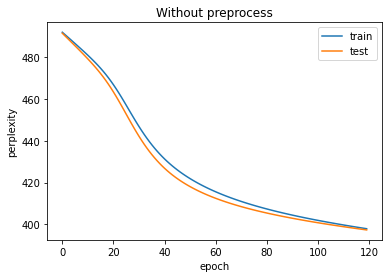

In [0]:
import matplotlib.pyplot as plt
net = Net(vectores.dim)
net.to(device)
p_train, p_test = Train(net, i_train_text, i_train_text, i_test_text, i_test_text, \
                        vectores.dim, vectores, epoch=120, lr=0.02, save_ram=True)
plt.plot(p_train, label='train')
plt.plot(p_test, label='test')
plt.ylabel('perplexity')
plt.xlabel('epoch')
plt.title("Without preprocess")
plt.legend()
plt.show()

In [0]:
import json
json.dump(p_train, open('p_train.json','w'))
json.dump(p_test, open('p_test.json','w'))

In [0]:
from google.colab import files
files.download('p_train.json') 
files.download('p_test.json') 